In [1]:
#@title Imports

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import os
import json
import pickle
import itertools
from tqdm import tqdm
import time

USER_INPUT FILES

if (two buildings): skip
calculate number of living rooms, bedrooms, bathrooms
create exterior_wall list
	find bottom-left point
	find_indices_of_edges_with_bottom_left_point
	find_outermost_clockwise_edge_id_from_bottom_left
	find_clockwise_chain
create connections_corners
	during exterior_wall find_clockwise_chain, append list of corners as we go
connections_rooms
	calculate number of each room_type
	for every edge in edge-to-room-mapping
	filter edge-to-room-mapping to have only the pairs (these are our room--to-room-adjacencies)

In [2]:
import numpy as np
data = np.load("/home/evalexii/Documents/IAAIP/datasets/housegan_clean_data.npy", None, True)


In [8]:
import matplotlib.pyplot as plt
ROOM_CLASS = {0: "exterior_wall", 1:"living_room", 2:"kitchen", 3:"bedroom", 4:"bathroom", 5:"missing", 6:"closet", 7:"balcony", 8:"corridor", 9:"dining_room", 10:"laundry_room"}

4 139 70 252


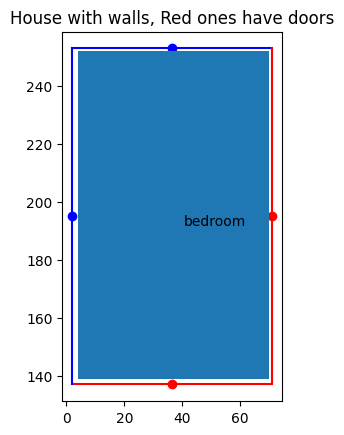

In [12]:
house_number = 11

edges = np.array(data[house_number][2])[:, 0:4]
edge_adjacencies = np.array(data[house_number][3])
doors = np.array(data[house_number][4])
rooms = np.array(data[house_number][1])
room_types = np.array(data[house_number][0])

#@title Plotting

def find_approximate_centroid(room_idx, house_edges, house_edge_adjacencies):
  # room_idx = data[house_nr][0].index(room_type)
  room_edge_ids = [id for id, edge in enumerate(house_edge_adjacencies) if room_idx in edge]
  room_edges = np.array(house_edges)[room_edge_ids]
  # Weight each edge by it's length
  weights = np.linalg.norm(room_edges[:,[2,3]] - room_edges[:,[0,1]], axis=1)**1.5
  # Uncomment below to remove weights
  # weights = np.ones(len(room_edges))
  # print(f"weights:\n {weights}")
  # print(f"roomedges:\n {room_edges}")
  x = np.concatenate([room_edges[:,0].reshape(-1,1), room_edges[:,2].reshape(-1,1)], axis=1)
  x_avg = np.mean(x, axis=1).reshape(-1,1)
  y = np.concatenate([room_edges[:,1].reshape(-1,1), room_edges[:,3].reshape(-1,1)], axis=1)
  y_avg = np.mean(y, axis=1).reshape(-1,1)
  room_edge_midpoints = np.concatenate((x_avg, y_avg), axis=1)
  # print(f"room_edge_midpoints:\n {room_edge_midpoints}")
  room_x, room_y = np.average(room_edge_midpoints, axis = 0, weights=weights)
  return room_x, room_y

# Plotting
fig, ax = plt.subplots()
ax.set_title("House with walls, Red ones have doors")
for num, edge in enumerate(edges):
  x = np.array([edge[0], edge[2]])
  x_avg = np.mean(x)
  y = np.array([edge[1], edge[3]])
  y_avg = np.mean(y)
  if num in doors:
    ax.plot(x,y, "r")
    plt.scatter(x_avg, y_avg, c="#FF0000")
  else:
    ax.plot(x,y, "b")
    plt.scatter(x_avg, y_avg, c="#0000FF")
for room_idx, room_type in enumerate(room_types):
  center_x, center_y = find_approximate_centroid(room_idx, edges, edge_adjacencies)
  plt.text(center_x+4, center_y-3, ROOM_CLASS[room_types[room_idx]])
  plt.scatter(center_x, center_y, c="#000000")
ax.set_aspect('equal')
for bb in rooms:
    x0, y0, x1, y1 = bb
    print(x0, y0, x1, y1)
    height = y1-y0
    width = x1-x0
    ax.add_patch(plt.Rectangle((x0,y0), width, height))
plt.show()

In [3]:
#@title Define file processing functions

def v_swap(edge):
  # edge = edge.copy
  edge[[0,1,2,3]] = edge[[2,3,0,1]]
  # return edge

def find_bottom_left_point(edges):
  """
  Input:
    N edges [x0, y0, x1, y1]

  Output:
    [x, y] with lowest L1-norm
  """
  min = 9e9
  min_coords = (9e9, 9e9)
  for edge in edges:
    l1_dist1 = np.sum(edge[0:2])
    if l1_dist1 < min:
      min = l1_dist1
      min_coords = edge[0:2]
    l1_dist2 = np.sum(edge[2:4])
    if l1_dist2 < min:
      min = l1_dist2
      min_coords = edge[2:4]
  return min_coords

def find_indices_of_edges_with_bottom_left_point(edges, bottomleft):
  """
  Input:
    edges: N edges [x0, y0, x1, y1]
    bottomleft: [x, y] with lowest L1-norm

  Output:
    indices of edges where bottomleft == [x0,y0] or [x1,y1]
  """
  ids = []
  for i, edge in enumerate(edges):
    if (edge[0] == bottomleft[0] and edge[1] == bottomleft[1]) or (edge[2] == bottomleft[0] and edge[3] == bottomleft[1]):
      ids += [i]
  return np.unique(np.array(ids))

def edges_swap_bottom_left_to_x0y0(edges):
  """
  Checks if L1-norm of x0,y0 < x1,y1. If not, swap
  """
  for edge in edges:
    if np.sum(edge[0:2]) > np.sum(edge[2:4]):
      v_swap(edge)

def find_outermost_clockwise_edge_id_from_bottom_left(edges, candidate_ids):
  """
  Input:
    edges: N edges [x0, y0, x1, y1]
    candidate_ids: indices of edges that have the bottom_left point

  Output:
    Index of edge pointing most along 135 degrees
  """
  x_axis = [1,0]
  vectors = edges[candidate_ids, 2:4] - edges[candidate_ids, 0:2]

  angles = np.arccos(
      np.sum(x_axis * vectors, axis=1) / np.linalg.norm(x_axis) / np.linalg.norm(vectors, axis=1)
  )

  return candidate_ids[np.argmax(angles)]

def find_clockwise_chain(edges, starting_id):
  """
  Input:
    TODO make input be just edges, not specifically exterior wall edges
    edges: N exterior_wall edges [id, x0, y0, x1, y1, D]
    starting_id: index of first edge in clockwise chain

  Output:
    List of N exterior_wall edges [id, x0, y0, x1, y1, D], in clockwise order
  """
  chain = edges[starting_id].reshape(1, -1)
  consumed_ids = [starting_id]
  last = chain[-1]

  while len(consumed_ids) < edges.shape[0]:
    last = chain[-1]

    for i, edge in enumerate(edges):
      if i in consumed_ids:
        continue

      if tuple(edge[1:3]) == tuple(last[3:5]):
        chain = np.concatenate((chain, edge.copy().reshape(1,-1)), axis=0)
        consumed_ids.append(i)
        break
      elif tuple(edge[3:5]) == tuple(last[3:5]):
        v_swap(edge[1:-1])
        chain = np.concatenate((chain, edge.copy().reshape(1,-1)), axis=0)
        consumed_ids.append(i)
        break

  return chain.tolist()

In [4]:
#@title Process folder of user-inputs

NUM_ROOM_TYPES = 11
ui_dicts = {}
i = 0
skipped_ids = []
for filename in tqdm(os.listdir("/home/evalexii/Documents/IAAIP/datasets/user_inputs_list_25_10/"), desc = 'tqdm() Progress Bar'):
  try:
    with open("/home/evalexii/Documents/IAAIP/datasets/user_inputs_list_25_10/" + filename) as file:
      ui_dict = json.load(file)
      ui_dict["filename"] = file.name[63::]
      ui_dict["floorplan_number"] = int(file.name[63:-5:])

      # flatten exterior_walls lists
      for i, ew in enumerate(ui_dict["exterior_walls"]):
        ui_dict["exterior_walls"][i] = [ew[0]]+ew[1]+[ew[2]]

      # re-order ews
      ews = np.array(ui_dict["exterior_walls"])
      ews_orig = ews.copy()
      ew_edges = ews[:,1:-1]
      bottom_left_point = find_bottom_left_point(ew_edges)
      candidate_start_edge_ids = find_indices_of_edges_with_bottom_left_point(ew_edges, bottom_left_point)
      edges_swap_bottom_left_to_x0y0(ew_edges[candidate_start_edge_ids])
      start_edge_id = find_outermost_clockwise_edge_id_from_bottom_left(ew_edges, candidate_start_edge_ids)
      ui_dict["exterior_walls"] = find_clockwise_chain(ews, start_edge_id)

      ew_mapping = {}
      # adjust ew ids
      for i, ew in enumerate(ui_dict["exterior_walls"]):
        ew_mapping[ew[0]] = i
        ew[0] = i

      # fix ew ids in connections_corners
      for i, cc in enumerate(ui_dict["connections_corners"]):
        cc[1] = ew_mapping[cc[1]]
        cc[3] = ew_mapping[cc[3]]

      # sort connections_corners
      cc = np.array(ui_dict["connections_corners"])
      ui_dict["connections_corners"] = [ui_dict["connections_corners"][i] for i in cc[:, 1].argsort()]

      # fix room ids in connections_rooms
      crs = ma.asarray(ui_dict["connections_rooms"])
      if not len(crs.shape) <=1:
        for room_type in range(NUM_ROOM_TYPES):
          # mask off all but room_type columns
          crs[:,1] = ma.masked
          crs[:,3:] = ma.masked
          room_type_indices = np.nonzero(crs == room_type)
          room_type_id_indices = (room_type_indices[0], room_type_indices[1]+1) # add one to columns to shift to room_type id columns
          if room_type_id_indices[0].shape[0] > 0:
            crs.mask = False
            if room_type == 0:
              for i in range(room_type_id_indices[0].shape[0]):
                crs[room_type_id_indices[0][i],room_type_id_indices[1][i]] = ew_mapping[crs[room_type_id_indices[0][i],room_type_id_indices[1][i]]]
            else:
              room_type_ids_orig = np.sort(np.unique(crs[room_type_id_indices].flatten())).tolist()
              room_type_ids_new = [i for i in range(len(room_type_ids_orig))]
              room_type_ids_map = dict(zip(room_type_ids_orig, room_type_ids_new))

              for i in range(room_type_id_indices[0].shape[0]):
                crs[room_type_id_indices[0][i],room_type_id_indices[1][i]] = room_type_ids_map[crs[room_type_id_indices[0][i],room_type_id_indices[1][i]]]

          crs.mask = False
          ui_dict["connections_rooms"] = crs.tolist()
  except:
    skipped_ids.append(ui_dict["floorplan_number"])
  ui_dicts[ui_dict["floorplan_number"]] = ui_dict

  i += 1
  if i > 0: break

tqdm() Progress Bar:   0%|          | 0/132569 [00:00<?, ?it/s]


In [6]:
sorted_ui_dicts = dict(sorted(ui_dicts.items()))
# sorted_ui_list = sorted_ui_dicts.values()
# with open("./user_input.p", "wb") as file:
#   pickle.dump(sorted_ui_list, file)
for key in sorted_ui_dicts:
  print(f"\n{key}")
  for inner_key in sorted_ui_dicts[key]:
      if isinstance(sorted_ui_dicts[key][inner_key], list):
        print(f"{inner_key}")
        for item in sorted_ui_dicts[key][inner_key]:
          print(item)
      else:
        print(f"{inner_key} {sorted_ui_dicts[key][inner_key]}")


30654
number_of_living_rooms 0
living_rooms_plus? False
number_of_bedrooms 4
bedrooms_plus? True
number_of_bathrooms 0
bathrooms_plus? True
exterior_walls
[0, 71, 33, 71, 88, 1]
[1, 71, 88, 71, 129, 0]
[2, 71, 129, 121, 129, 0]
[3, 121, 129, 121, 88, 0]
[4, 121, 88, 121, 68, 1]
[5, 121, 68, 139, 68, 0]
[6, 139, 68, 158, 68, 0]
[7, 158, 68, 158, 91, 1]
[8, 158, 91, 158, 131, 0]
[9, 158, 131, 197, 131, 1]
[10, 197, 131, 245, 131, 1]
[11, 245, 131, 245, 91, 0]
[12, 245, 91, 245, 33, 0]
[13, 245, 33, 210, 33, 1]
[14, 210, 33, 173, 33, 1]
[15, 173, 33, 139, 33, 0]
[16, 139, 33, 122, 33, 0]
[17, 122, 33, 100, 33, 0]
[18, 100, 33, 71, 33, 1]
connections_corners
[0, 0, 0, 1, 0.0, 0]
[0, 1, 0, 2, -90.0, 0]
[0, 2, 0, 3, -90.0, 0]
[0, 3, 0, 4, 0.0, 0]
[0, 4, 0, 5, 90.0, 0]
[0, 5, 0, 6, 0.0, 0]
[0, 6, 0, 7, 90.0, 0]
[0, 7, 0, 8, 0.0, 0]
[0, 8, 0, 9, -90.0, 0]
[0, 9, 0, 10, 0.0, 0]
[0, 10, 0, 11, -90.0, 0]
[0, 11, 0, 12, 0.0, 0]
[0, 12, 0, 13, -90.0, 0]
[0, 13, 0, 14, 0.0, 0]
[0, 14, 0, 15, 0.0, 0

In [ ]:
#@title Load decision sequence #1
with open("/content/drive/MyDrive/IAAIP/dataset/partial_graphs.pickle", "rb") as file:
  DS1 = pickle.load(file)

In [ ]:
#@title Load decision sequence #2


In [ ]:
#@title Peruse DS's
sorted_DS1 = dict(sorted(DS1.items()))
print(list(sorted_DS1.items())[0][1][0:5])